In [17]:
import optuna
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
import os
from joblib import dump

# CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE.type

# Fix random seed
seed = 42
torch.manual_seed(seed)
if DEVICE.type == 'cuda':
	torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

# Pre-processing input data

In [18]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')

target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Spearman U Kendall correlation feature selection > 0.4
# features = ["total_time","max_ram_usage","brk","munmap","rss","vms","shared","data"]
# mean error: 3.7178027629852295 | std error: 10.728959083557129

# log for total_times
train_df[[target, 'total_time']] = np.log1p(train_df[[target, 'total_time']])
test_df[[target, 'total_time']] = np.log1p(test_df[[target, 'total_time']])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

if DEVICE.type == 'cuda':
	X_train = X_train.to(DEVICE)
	y_train = y_train.to(DEVICE)
	X_test = X_test.to(DEVICE)
	y_test = y_test.to(DEVICE)

In [19]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: Feedforward Neural Network

In [20]:
class History:
	def __init__(self):
		self.loss = []
		self.val_loss = []
	
	def append(self, loss, val_loss):
		self.loss.append(loss)
		self.val_loss.append(val_loss)

def inv_scaling(y, y_scaler, d=False):
    if d:
        return y_scaler.inverse_transform(y.detach().cpu().numpy().reshape(-1, 1))
    return y_scaler.inverse_transform(y.cpu().numpy().reshape(-1, 1))

In [21]:
class FeedforwardModel(nn.Module):
	def __init__(self, input_dim, dropout=0.1):
		super(FeedforwardModel, self).__init__()
		# layers
		self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
			nn.Linear(64, 32),
			nn.ReLU(),
			nn.Dropout(p=dropout),
            nn.Linear(32, 1),
        )
	
	def forward(self, x):
		return self.model(x)
	
	def fit(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, learning_rate=0.0002, verbose=True, patience=10):
		train_data = TensorDataset(X_train, y_train)
		test_data = TensorDataset(X_test, y_test)
		train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
		test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

		best_val_loss = np.inf
		epoch_no_improve = 0
		best_model_state = None
		optimizer = optim.Adam(self.parameters(), lr=learning_rate)
		criterion = nn.MSELoss()
		history = History()

		for epoch in range(epochs):
			self.train()
			total_loss = 0
			for batch_X, batch_y in train_loader:
				optimizer.zero_grad()
				output = self(batch_X)
				loss = torch.sqrt(criterion(output, batch_y))
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			avg_loss = total_loss / len(train_loader)

			self.eval()
			total_val_loss = 0
			with torch.no_grad():
				for batch_X, batch_y in test_loader:
					output = self(batch_X)
					val_loss = torch.sqrt(criterion(output, batch_y))
					total_val_loss += val_loss.item()
				avg_val_loss = total_val_loss / len(test_loader)
			
			if verbose:
				print(f"Epoch: {epoch+1} - Loss: {avg_loss} - Val Loss: {avg_val_loss}")

			# Early stopping
			if avg_val_loss < best_val_loss:
				best_val_loss = avg_val_loss
				best_model_state = self.state_dict()
				epoch_no_improve = 0
			else:
				epoch_no_improve += 1
				if epoch_no_improve >= patience:
					print(f"Early stopping at epoch {epoch+1}")
					break
			history.append(avg_loss, avg_val_loss)
		
		if best_model_state is not None:
			self.load_state_dict(best_model_state)
		
		return history

	def predict(model, X):
		model.eval()
		with torch.no_grad():
			prediction = torch.nn.functional.relu(model(X))
		return prediction

# Hyperparameters Optimization

In [22]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test, input_dim):
	dropout = trial.suggest_float('dropout', 0.1, 0.5)
	learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
	num_epochs = trial.suggest_int('num_epochs', 10, 100)

	# Model initialization 
	model = FeedforwardModel(input_dim, dropout)
	if DEVICE.type == 'cuda':
		model = model.to(DEVICE)
	# Fit model
	history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=learning_rate)
	loss = history.loss[-1]
	val_loss = history.val_loss[-1]
	print(f"Trial: {trial.number} - RMSE Loss: {loss} - RMSE Val Loss: {val_loss} - epochs: {len(history.loss)}")
	return val_loss.item()

n_trials = 250
study = None

In [23]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, len(features)), n_trials=n_trials)

In [24]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {y_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

# Training

In [25]:
# hyperparameters
if study is not None:
	dropout = study.best_trial.params['dropout']
	lr = study.best_trial.params['learning_rate']
	num_epochs = study.best_trial.params['num_epochs']
else:
	dropout = 0.1
	lr = 0.0002
	num_epochs = 100

In [76]:
# Model initialization
model = FeedforwardModel(len(features), dropout)
if DEVICE.type == 'cuda':
	model = model.to(DEVICE)
# Fit model
history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=lr)
loss = history.loss[-1]
val_loss = history.val_loss[-1]

Epoch: 1 - Loss: 0.07273454223744337 - Val Loss: 0.021677245222064045
Epoch: 2 - Loss: 0.03756051070338371 - Val Loss: 0.016522630696912403
Epoch: 3 - Loss: 0.03343834131774477 - Val Loss: 0.017842968694501967
Epoch: 4 - Loss: 0.03149859747876648 - Val Loss: 0.014917043792163801
Epoch: 5 - Loss: 0.029684640424788192 - Val Loss: 0.014868899558814715
Epoch: 6 - Loss: 0.02885125648989095 - Val Loss: 0.014609959794412259
Epoch: 7 - Loss: 0.02791534533738315 - Val Loss: 0.012409867745296541
Epoch: 8 - Loss: 0.02738888470207786 - Val Loss: 0.011138705477766022
Epoch: 9 - Loss: 0.027018139750282014 - Val Loss: 0.011214078277101653
Epoch: 10 - Loss: 0.026684262575874286 - Val Loss: 0.010521624013961417
Epoch: 11 - Loss: 0.026287812541843366 - Val Loss: 0.010986149745249857
Epoch: 12 - Loss: 0.02613854052938868 - Val Loss: 0.012152204178613431
Epoch: 13 - Loss: 0.02572707970195802 - Val Loss: 0.010003359078493593
Epoch: 14 - Loss: 0.02537294180926545 - Val Loss: 0.012654193391715668
Epoch: 15 -

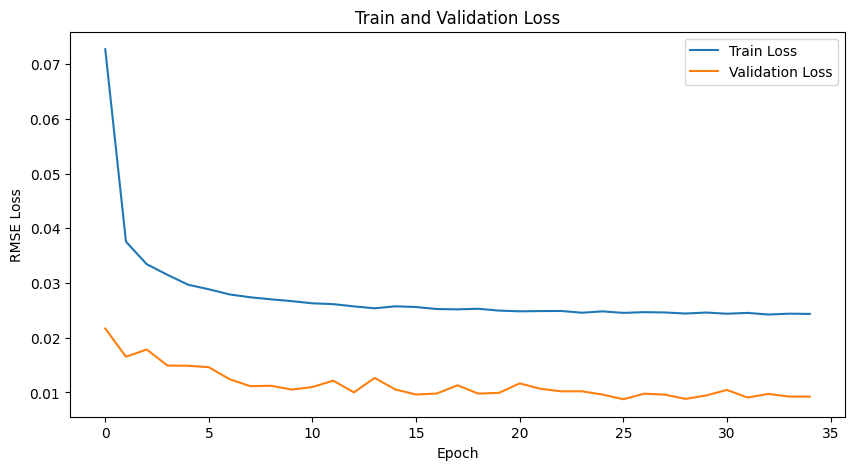

In [77]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.loss, label='Train Loss')
plt.plot(history.val_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

In [78]:
# save model
torch.save(model, '../models/feedforward_model.pt')

# Describe Validation

In [26]:
model = torch.load('../models/feedforward_model.pt').to(DEVICE)

In [27]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	predictions = model.predict(X)
	predictions = np.expm1(inv_scaling(predictions, y_scaler))
	y_scaled = np.expm1(inv_scaling(y, y_scaler))
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [28]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [29]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 22.91146469116211 | Std actual: 42.6287956237793
Mean actual: 23.40154457092285 | Std actual: 44.03071594238281
Mean Error: 1.6019675731658936 | Std Error: 4.249248027801514
Min instance
total_time                                                             0.42
total_cpu_usage                                                        0.99
max_ram_usage                                                     20.070312
brand_raw                          Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    56
l2_cache_size                                                          70.0
l3_cache_size                                                          42.0
l2_cache_line_size                                                      256
l

In [30]:
# get index of total_time_target < 2.00
index = test_df_og[test_df_og['total_time_target'] < 2.0].index
X_test_low = X_test[index]
y_test_low = y_test[index]
test_df_og_low = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_low, y_test_low, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_low, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target < 2.0")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_low.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_low.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target < 2.0
Mean prediction: 0.7016081809997559 | Std actual: 0.5688784122467041
Mean actual: 0.7286967039108276 | Std actual: 0.5568326115608215
Mean Error: 0.07469198107719421 | Std Error: 0.07763296365737915
Min instance
total_time                                                             0.42
total_cpu_usage                                                        0.99
max_ram_usage                                                     20.070312
brand_raw                          Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    56
l2_cache_size                                                          70.0
l3_cache_size                                                          42.0
l2_cache_line_size                      

In [31]:
# get index of 2.00 > total_time_target > 150.0
index = test_df_og[(test_df_og['total_time_target'] <= 150.0) & (test_df_og['total_time_target'] >= 2.0)].index
X_test_med = X_test[index]
y_test_med = y_test[index]
test_df_og_med = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_med, y_test_med, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_med, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target in [2.0, 150.0]")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_med.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_med.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target in [2.0, 150.0]
Mean prediction: 25.988929748535156 | Std actual: 21.469900131225586
Mean actual: 26.37005043029785 | Std actual: 22.300119400024414
Mean Error: 1.7617844343185425 | Std Error: 2.17958664894104
Min instance
total_time                                                             7.25
total_cpu_usage                                                        0.99
max_ram_usage                                                     31.960938
brand_raw                         Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                     8
l2_cache_size                                                           2.0
l3_cache_size                                                          10.0
l2_cache_line_size                 

In [32]:
# get index of total_time_target > 150.0
index = test_df_og[test_df_og['total_time_target'] > 150.0].index
X_test_high = X_test[index]
y_test_high = y_test[index]
test_df_og_high = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_high, y_test_high, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test_high, y_scaler))
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target > 150.0")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_high.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_high.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target > 150.0
Mean prediction: 256.5651550292969 | Std actual: 29.27117919921875
Mean actual: 266.41851806640625 | Std actual: 12.794624328613281
Mean Error: 19.013731002807617 | Std Error: 16.774213790893555
Min instance
total_time                                                           276.45
total_cpu_usage                                                        0.99
max_ram_usage                                                    170.089844
brand_raw                          Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    56
l2_cache_size                                                          70.0
l3_cache_size                                                          42.0
l2_cache_line_size                        

# SHAP Analysis

In [33]:
y_prediction = np.expm1(inv_scaling(model.predict(X_test[::30]), y_scaler))
test_df_og = test_df_og[::30]

In [34]:
import shap
train_random_indices = np.random.choice(X_train.shape[0], 2500, replace=False)
X_train_random = X_train[train_random_indices]
explainer = shap.DeepExplainer(model, X_train_random)
shap_values = explainer.shap_values(X_test[::30])
X_test_non_scaled = x_scaler.inverse_transform(X_test[::30].cpu().numpy())
X_test_non_scaled[:, 0] = np.expm1(X_test_non_scaled[:, 0])
shap.initjs()

In [41]:
shap.force_plot(explainer.expected_value[0], shap_values[:, :, 0], X_test_non_scaled, feature_names=features)

Prediction: 0.2550715208053589 | Actual: 0.33 | Error: 0.07492847919464113


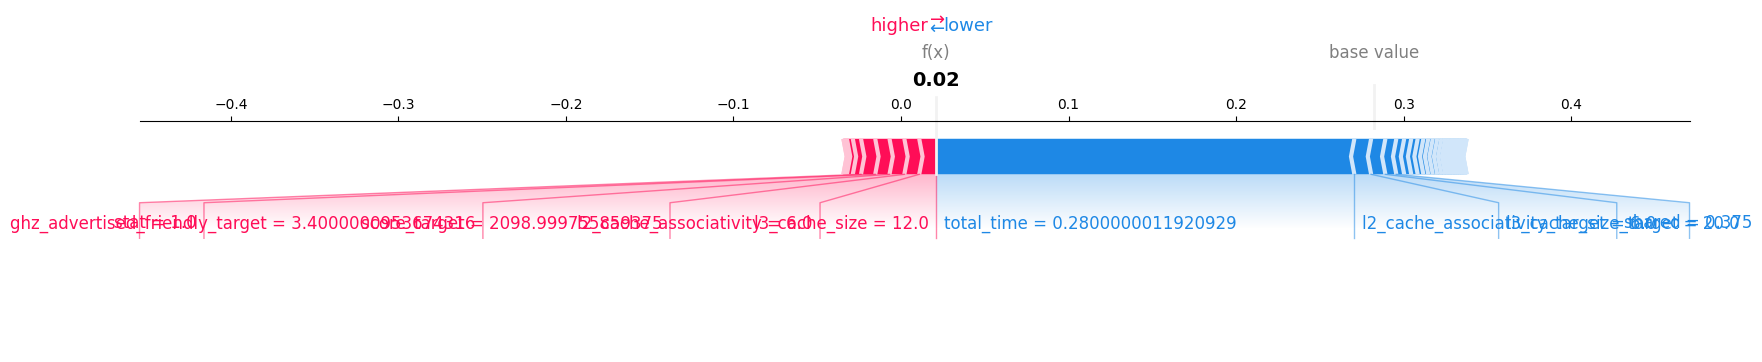

In [36]:
instance = 54
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']} | Error: {abs(y_prediction[instance].item() - test_df_og.iloc[instance]['total_time_target'])}")
shap.force_plot(explainer.expected_value[0], shap_values[instance, :, 0], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 12.355301856994629 | Actual: 11.71 | Error: 0.645301856994628


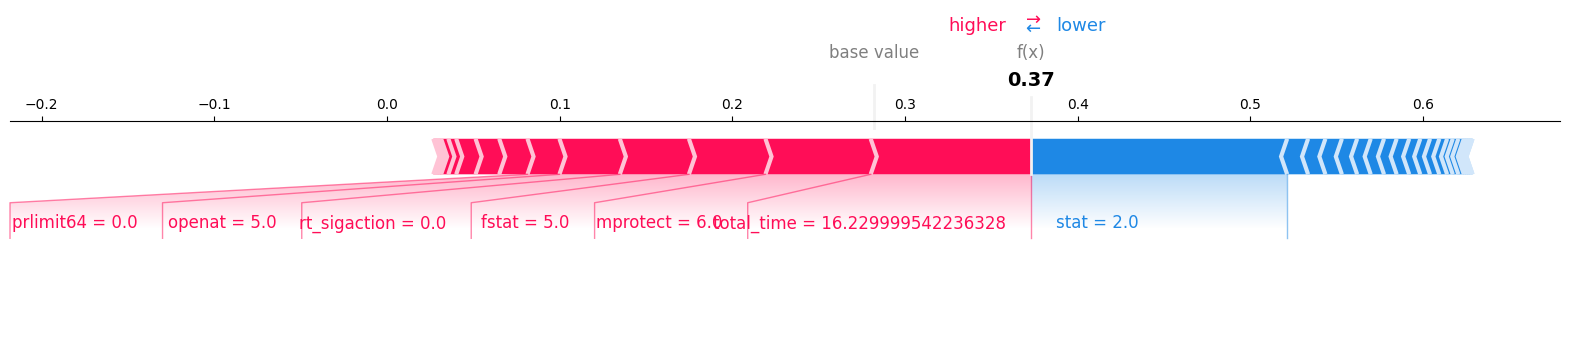

In [38]:
instance = 143
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']} | Error: {abs(y_prediction[instance].item() - test_df_og.iloc[instance]['total_time_target'])}")
shap.force_plot(explainer.expected_value[0], shap_values[instance, :, 0], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 233.10740661621094 | Actual: 269.24 | Error: 36.13259338378907


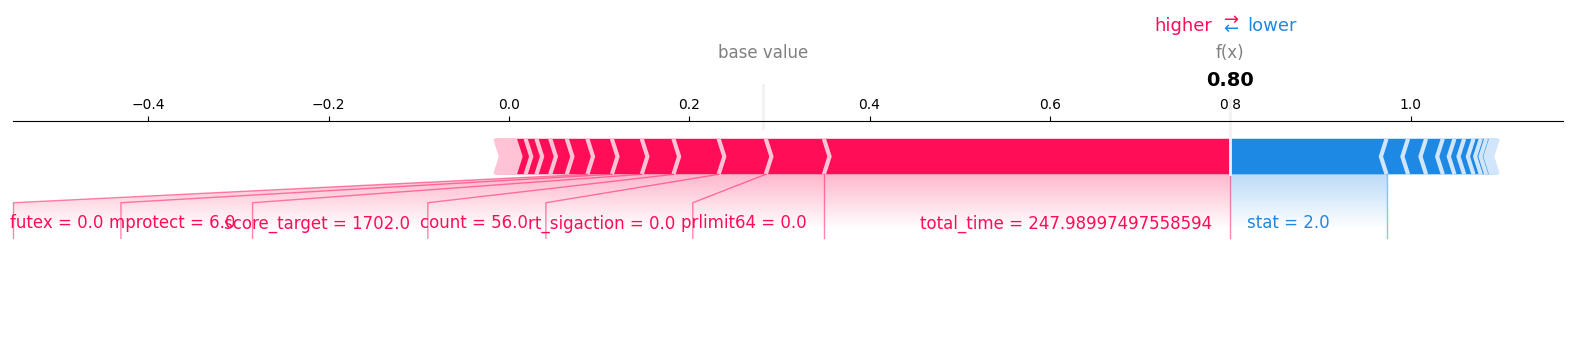

In [39]:
instance = 1
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']} | Error: {abs(y_prediction[instance].item() - test_df_og.iloc[instance]['total_time_target'])}")
shap.force_plot(explainer.expected_value[0], shap_values[instance, :, 0], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

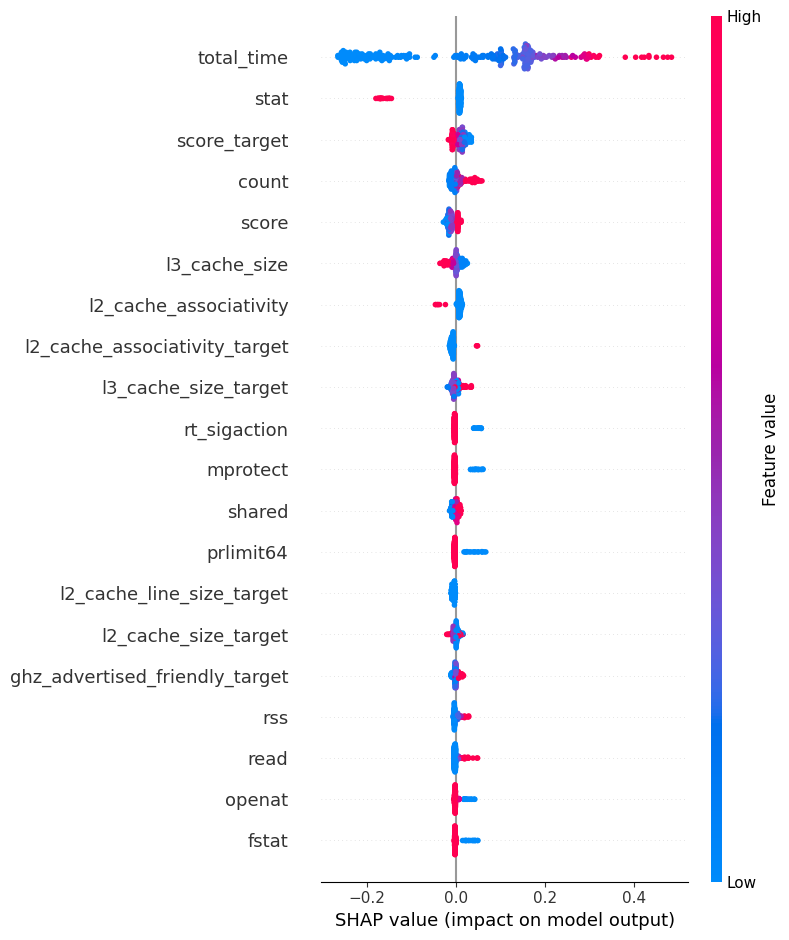

In [88]:
# Sumarize the effects of all the features
shap.summary_plot(shap_values[:,:,0], X_test_non_scaled, feature_names=features)

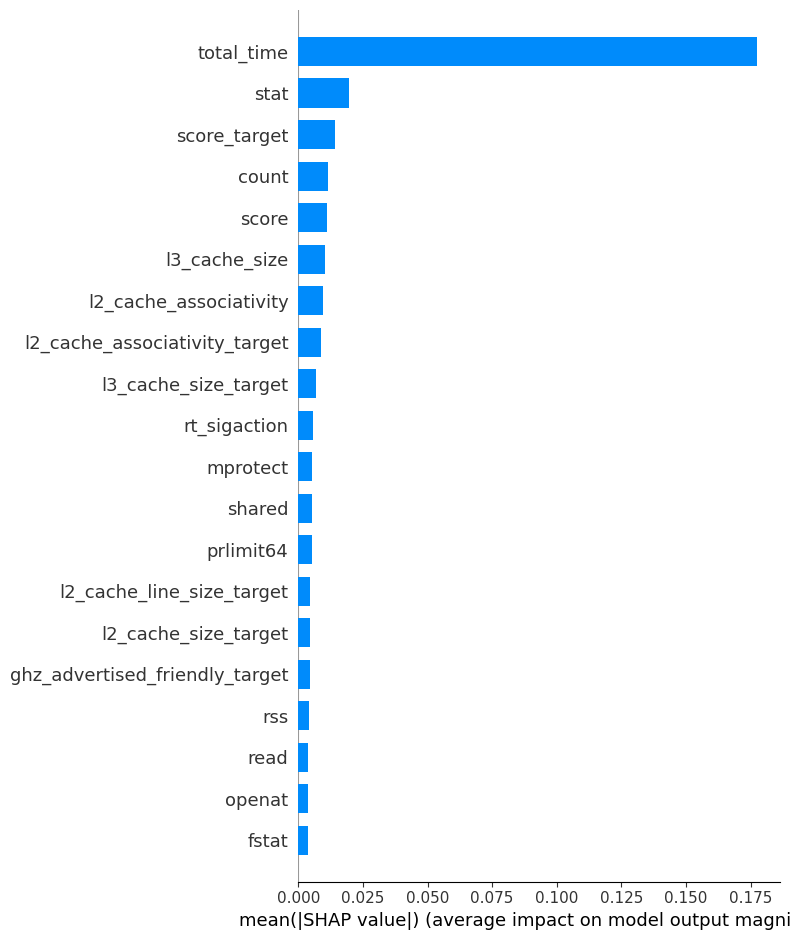

In [89]:
shap.summary_plot(shap_values[:,:,0], X_test_non_scaled, feature_names=features, plot_type='bar')

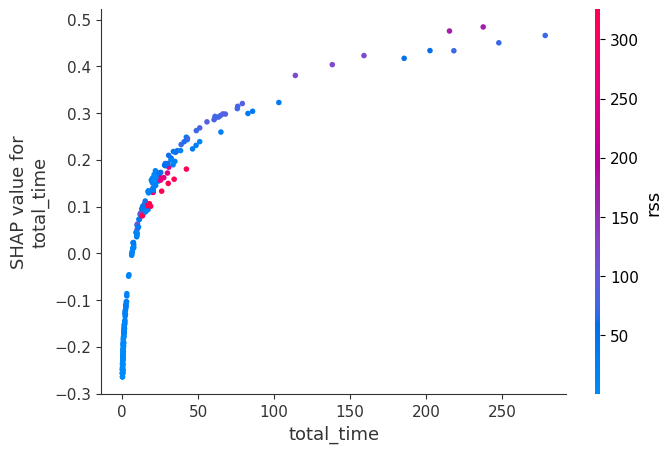

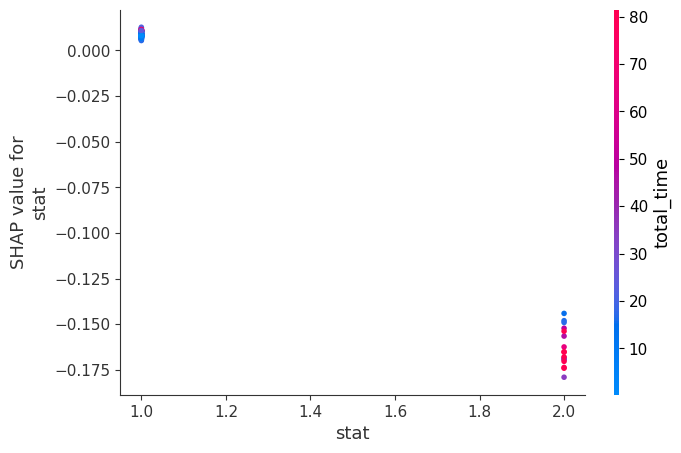

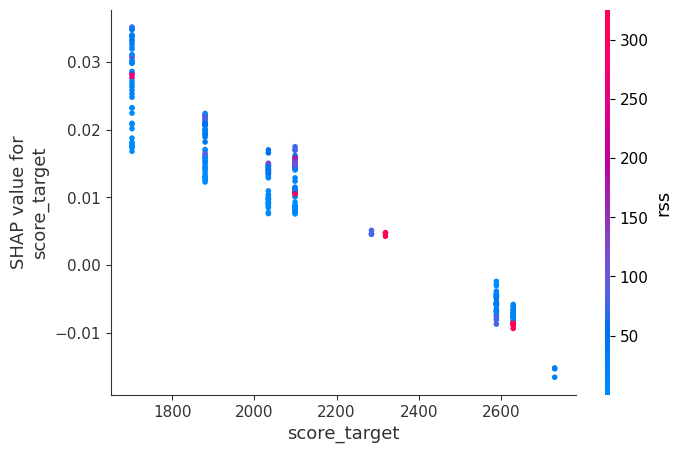

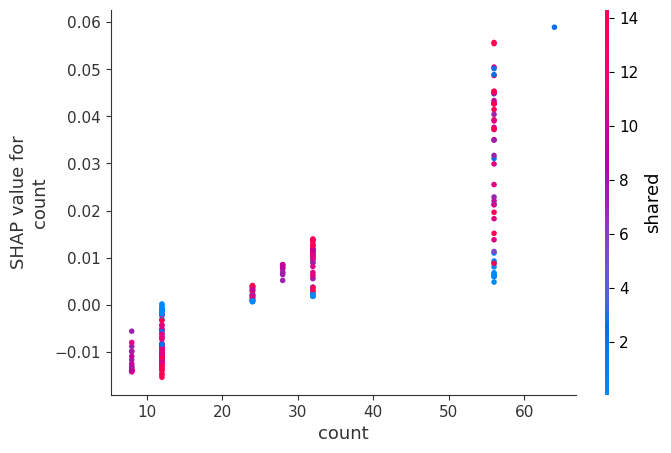

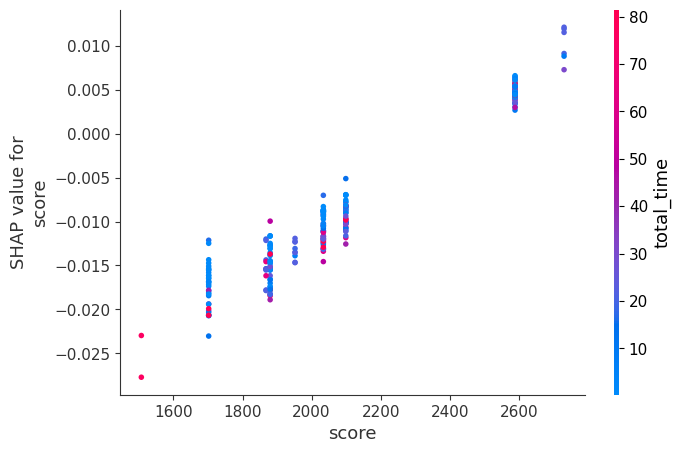

In [90]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the test set)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html
top_inds = np.argsort(-np.sum(np.abs(shap_values[:,:,0]), 0))
for i in range(5):
    # shap.common.approximate_interactions is used to pick what seems to be the strongest interaction 
    shap.dependence_plot(top_inds[i], shap_values[:,:,0], X_test_non_scaled, feature_names=features)